In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from optuna.integration import KerasPruningCallback
from sklearn.preprocessing import StandardScaler
import lightning

lightning.seed_everything(123456)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

%matplotlib inline

/home/ventus/university/data-mining/.env/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 123456


In [3]:
df = pd.read_csv("../data/mpi_saale_2021b.csv", parse_dates=['Date Time'], index_col='Date Time')

# Extract features and target
# features = df.values #df.drop(columns=["T (degC)"]).values
features = df["T (degC)"].values #df.drop(columns=["T (degC)"]).values
target = df["T (degC)"].values

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

sequence_length = 30
sequence_length = 30
dataset = keras.utils.timeseries_dataset_from_array(
    scaled_features, target[sequence_length:], sequence_length
)

num_samples = len(dataset)
train_size = int(0.7 * num_samples)
val_size = int(0.2 * num_samples)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

ValueError: `sampling_rate` must be lower than the length of the data. Received: sampling_rate=1, for data of length 1

In [ ]:
df.head()

,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),H2OC (mmol/mol),...,ST008 (degC),ST016 (degC),ST032 (degC),ST064 (degC),ST128 (degC),SM008 (%),SM016 (%),SM032 (%),SM064 (%),SM128 (%)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2021 00:10:00,994.66,15.30,88.0,9.64,288.89,13.33,17.41,15.32,2.09,15.40,...,19.71,20.04,19.46,17.47,14.14,24.74,21.69,23.17,26.47,32.96
01.07.2021 00:20:00,994.60,15.16,89.9,9.76,288.76,13.52,17.26,15.51,1.74,15.60,...,19.67,20.02,19.46,17.47,14.14,24.74,21.69,23.17,26.47,32.95
01.07.2021 00:30:00,994.56,15.18,90.9,9.88,288.78,13.71,17.28,15.71,1.57,15.79,...,19.64,20.00,19.45,17.47,14.14,24.74,21.69,23.17,26.47,32.95
01.07.2021 00:40:00,994.55,15.73,86.7,9.76,289.33,13.52,17.90,15.52,2.38,15.60,...,19.61,19.98,19.45,17.47,14.14,24.73,21.69,23.17,26.47,32.95
01.07.2021 00:50:00,994.58,16.18,84.3,9.77,289.78,13.53,18.42,15.53,2.89,15.61,...,19.57,19.96,19.45,17.46,14.14,24.73,21.69,23.17,26.47,32.95


In [ ]:
from keras import regularizers

def build_model(trial, model_type="lstm"):
    model = keras.Sequential()
    model.add(keras.Input((30,30)))
    n_layers = trial.suggest_int("n_layers", 1, 2)

    for i in range(n_layers):
        units = trial.suggest_int(f"units_layer_{i}", 32, 128, step=32)
        reg = trial.suggest_float(f"l2_reg_layer_{i}", 1e-6, 1e-2, log=True)
        return_seq = i < n_layers - 1

        if model_type == "lstm":
            model.add(keras.layers.LSTM(units, return_sequences=return_seq, kernel_regularizer=regularizers.l2(reg)))
        else:
            model.add(keras.layers.GRU(units, return_sequences=return_seq, kernel_regularizer=regularizers.l2(reg)))

        dropout = trial.suggest_float(f"dropout_layer_{i}", 0.0, 0.5)
        model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(1))

    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model



In [ ]:
from keras.callbacks import EarlyStopping

def objective(trial: optuna.Trial, model_type="lstm"):
    model = build_model(trial, model_type)

    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    pruning_cb = KerasPruningCallback(trial, monitor="val_loss")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop, pruning_cb],
        verbose=0
    )

    return min(history.history["val_loss"])

In [ ]:
def make_study(name: str):
	return optuna.create_study(
		direction="minimize",
		study_name=name,
		storage="sqlite:///../data/lab4-optuna.db",
		load_if_exists=True,
		pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
	)


In [ ]:
def fit_model(best_trial: optuna.Trial, model_type="lstm"):
	best_model = build_model(best_trial, model_type=model_type)
	history = best_model.fit(
		train_ds,
		validation_data=val_ds,
		callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
		epochs=30
	)
	return best_model, history

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_prediction(targets, predictions):
	# Plot actual vs predicted values
	plt.figure(figsize=(12, 6))
	plt.plot(targets, label="True Values")
	plt.plot(predictions, label="Predicted Values", color="darkred")
	plt.xlabel("Time Step")
	plt.ylabel("Temperature (degC)")
	plt.title("True vs Predicted Temperature")
	plt.legend()
	plt.show()

	# Compute MAE and RMSE
	mae = mean_absolute_error(targets, predictions)
	rmse = mean_squared_error(targets, predictions)**0.5

	print(f"Mean Absolute Error (MAE): {mae}")
	print(f"Root Mean Squared Error (RMSE): {rmse}")

def evaluate_candidate(model):
	# Get model predictions for the test dataset
	test_features = np.vstack([x[0] for x in test_ds])
	test_target = np.hstack([x[1] for x in test_ds])

	# Make predictions
	test_predictions = model.predict(test_features)
	evaluate_prediction(test_target, test_predictions)

## Naive Forecast

In [ ]:
class NaiveForecast:
    def predict(self, X):
        b, t, f = X.shape
        X = X.reshape(-1, f)
        out = scaler.inverse_transform(X)
        print(out.shape)
        return out.reshape(b, t, f)[:,-10, 1:2]     


2025-04-13 10:17:23.905239: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(83580, 30)


2025-04-13 10:17:24.177332: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


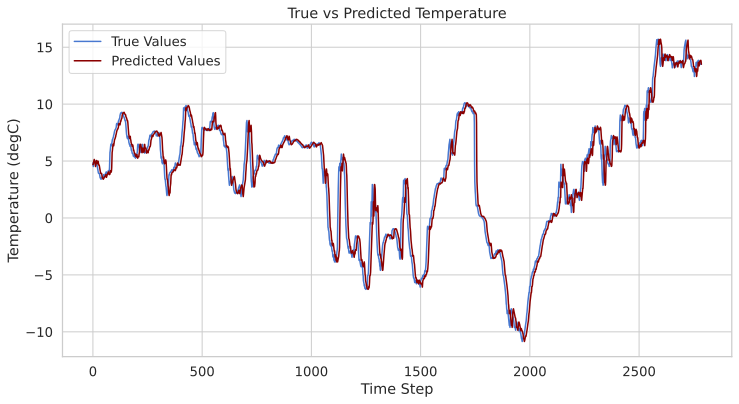

Mean Absolute Error (MAE): 0.86913496051687
Root Mean Squared Error (RMSE): 1.3203088540974734


In [ ]:
evaluate_candidate(NaiveForecast())

## LSTM

In [ ]:
from functools import partial
study = make_study("lstm_forecasting")
study.optimize(partial(objective, model_type="lstm"), n_trials=0, n_jobs=2)

[I 2025-04-13 10:17:24,556] Using an existing study with name 'lstm_forecasting' instead of creating a new one.


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 139.4564 - val_loss: 2.8247
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 20.9343 - val_loss: 3.5406
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.1475 - val_loss: 3.1141
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.3584 - val_loss: 2.3906
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.8769 - val_loss: 2.0652
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.3604 - val_loss: 1.6919
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.0162 - val_loss: 1.5170
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.9143 - val_loss: 1.3552
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.7347 - val_loss: 1.1923
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.6476 - val_loss: 1.0645
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.5616 - val_loss: 0.9719
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━

2025-04-13 10:19:41.508013: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


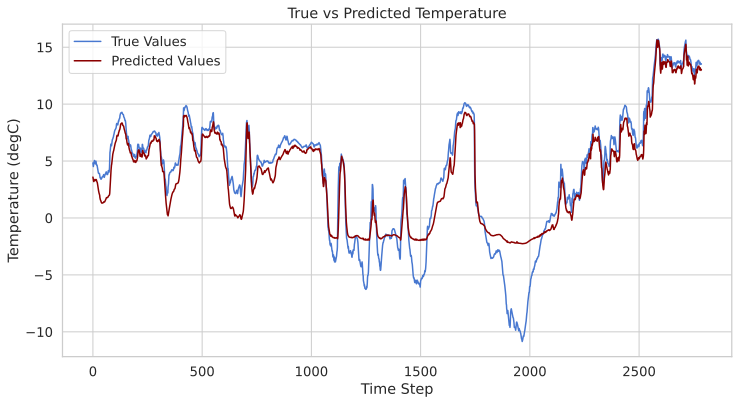

Mean Absolute Error (MAE): 1.3509909129758917
Root Mean Squared Error (RMSE): 1.944783079979613
CPU times: user 4min 3s, sys: 1min, total: 5min 3s
Wall time: 2min 18s


In [ ]:
%%time
best_lstm, history = fit_model(study.best_trial, model_type="lstm")
evaluate_candidate(best_lstm)

## GRU

In [ ]:
from functools import partial
study = make_study("gru_forecasting")
study.optimize(partial(objective, model_type="gru"), n_trials=0, n_jobs=2)

[I 2025-04-13 10:19:42,803] Using an existing study with name 'gru_forecasting' instead of creating a new one.


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 96.5571 - val_loss: 99.2219
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 45.0574 - val_loss: 52.3374
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 17.3756 - val_loss: 9.9935
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 7.2067 - val_loss: 7.2569
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 3.6256 - val_loss: 7.2424
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 2.3300 - val_loss: 5.1527
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.7108 - val_loss: 4.2670
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.4173 - val_loss: 3.3960
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.2280 - val_loss: 2.7444
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.1481 - val_loss: 3.2704
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.5596 - val_loss: 1.9376
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━

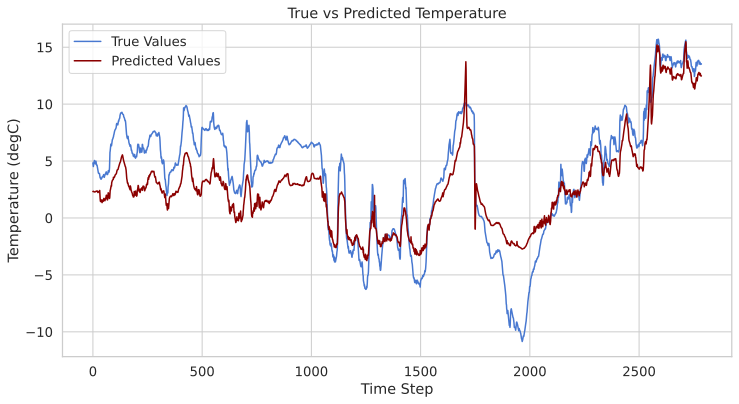

Mean Absolute Error (MAE): 2.394834887896693
Root Mean Squared Error (RMSE): 2.827816309033834
CPU times: user 3min 9s, sys: 42.4 s, total: 3min 52s
Wall time: 1min 55s


In [ ]:
%%time
best_gru, history = fit_model(study.best_trial, model_type="gru")
evaluate_candidate(best_gru)